**This is a notebook to train a Physics Informed Neural Network on Burger's equation.**

The one dimensional Burger's equation is given by:
$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}; \;\;\; x \in [-1, 1], t \in [0,1]$$


In [20]:
# Import necessary libraries
import torch 
import torch.nn as nn
import numpy as np
import scipy
from pyDOE import lhs
import time 
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [21]:
# Define a network for predicting u

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

layer_list = []
for l in range(len(layers)-1):
    layer_list.append(nn.Linear(layers[l],layers[l+1]))
    layer_list.append(nn.Tanh())

    
net_u = nn.Sequential(*layer_list)

In [22]:
# Define a network for predicting f

def net_f(x, t, nu):
    x.requires_grad = True
    t.requires_grad = True
    u = net_u(torch.cat([x,t],1))
    u_t = torch.autograd.grad(u, t, create_graph=True, grad_outputs=torch.ones_like(u), 
                     allow_unused=True)[0]
    u_x = torch.autograd.grad(u, x, create_graph=True,
                     grad_outputs=torch.ones_like(u), 
                     allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True,
                     grad_outputs=torch.ones_like(u), 
                     allow_unused=True)[0]
    f = u_t + u * u_x - nu * u_xx
    return f

In [23]:
# Functions to train and predict

def train_step( X_u_train_t, u_train_t, X_f_train_t, opt, nu):
    x_u = X_u_train_t[:,0:1]
    t_u = X_u_train_t[:,1:2]
    x_f = X_f_train_t[:,0:1]
    t_f = X_f_train_t[:,1:2]
    opt.zero_grad()
    u_nn = net_u(torch.cat([x_u, t_u],1))
    f_nn = net_f(x_f,t_f, nu)
    loss =  torch.mean(torch.square(u_nn - u_train_t)) + torch.mean(torch.square(f_nn))
    loss.backward()
    opt.step() 
    return loss

def predict(X_star_tf):
    x_star = X_star_tf[:,0:1]
    t_star = X_star_tf[:,1:2]
    u_pred = net_u(torch.cat([x_star, t_star],1))
    return u_pred

In [24]:
# Parameter definitions

nu = 0.01/np.pi # Viscosity
N_u = 100 # Number of Initial and Boundary data points
N_f = 10000 # Number of residual point
Nmax=  5000


In [25]:
# Load and process data

data = scipy.io.loadmat('./burgers_shock.mat')

t = data['t'].flatten()[:,None] # The temporal domain is discretized between 0 to 1 in 100 points
x = data['x'].flatten()[:,None] # The spatial domain is discretized between -1 to 1 in 256 points
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

In [26]:
# Define the domain and boundary conditions

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

# Initial Condition
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# Boundary condition -1
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# Boundary condition 1
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

In [27]:
# Generate training data

X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_u_train_t = torch.tensor(X_u_train, dtype=torch.float32)
u_train_t =   torch.tensor(u_train, dtype=torch.float32)
X_f_train_t = torch.tensor(X_f_train, dtype=torch.float32)

In [28]:
# Define optimizer 

lr = 1e-3
optimizer = torch.optim.Adam(net_u.parameters(),lr=lr)

In [29]:
# Run the model

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(X_u_train_t, u_train_t, X_f_train_t, optimizer, nu)
    loss.append(loss_.detach().numpy())
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Iteration is: 0 and loss is: 0.2822549641132355
Iteration is: 1 and loss is: 0.27922219038009644
Iteration is: 2 and loss is: 0.27714598178863525
Iteration is: 3 and loss is: 0.2759135067462921
Iteration is: 4 and loss is: 0.27526623010635376
Iteration is: 5 and loss is: 0.2748088836669922
Iteration is: 6 and loss is: 0.27417081594467163
Iteration is: 7 and loss is: 0.2731819450855255
Iteration is: 8 and loss is: 0.2718614935874939
Iteration is: 9 and loss is: 0.27030834555625916
Iteration is: 10 and loss is: 0.26861506700515747
Iteration is: 11 and loss is: 0.26682689785957336
Iteration is: 12 and loss is: 0.2649330794811249
Iteration is: 13 and loss is: 0.2628763020038605
Iteration is: 14 and loss is: 0.26057326793670654
Iteration is: 15 and loss is: 0.2579382359981537
Iteration is: 16 and loss is: 0.2549036145210266
Iteration is: 17 and loss is: 0.25143298506736755
Iteration is: 18 and loss is: 0.24752753973007202
Iteration is: 19 and loss is: 0.2432279884815216
Iteration is: 20 and

In [30]:
# predict and compute errors

X_star_t = torch.tensor(X_star, dtype=torch.float32)
u_pred = predict(X_star_t)
u_pred = u_pred.detach().numpy()
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)

Error u: 1.884811e-01


Loss convergence


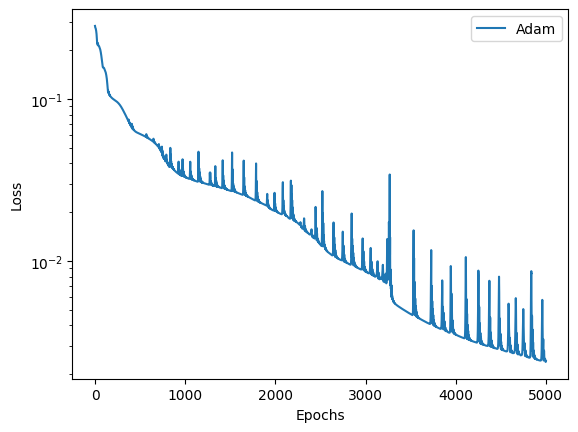

In [31]:
# plot the results

print('Loss convergence')
loss = np.array(loss)
range_adam = np.arange(0, Nmax+1)
plt.semilogy(range_adam, loss, label='Adam')
#plt.plot(epochs, loss, label = 'adam optimizer')
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

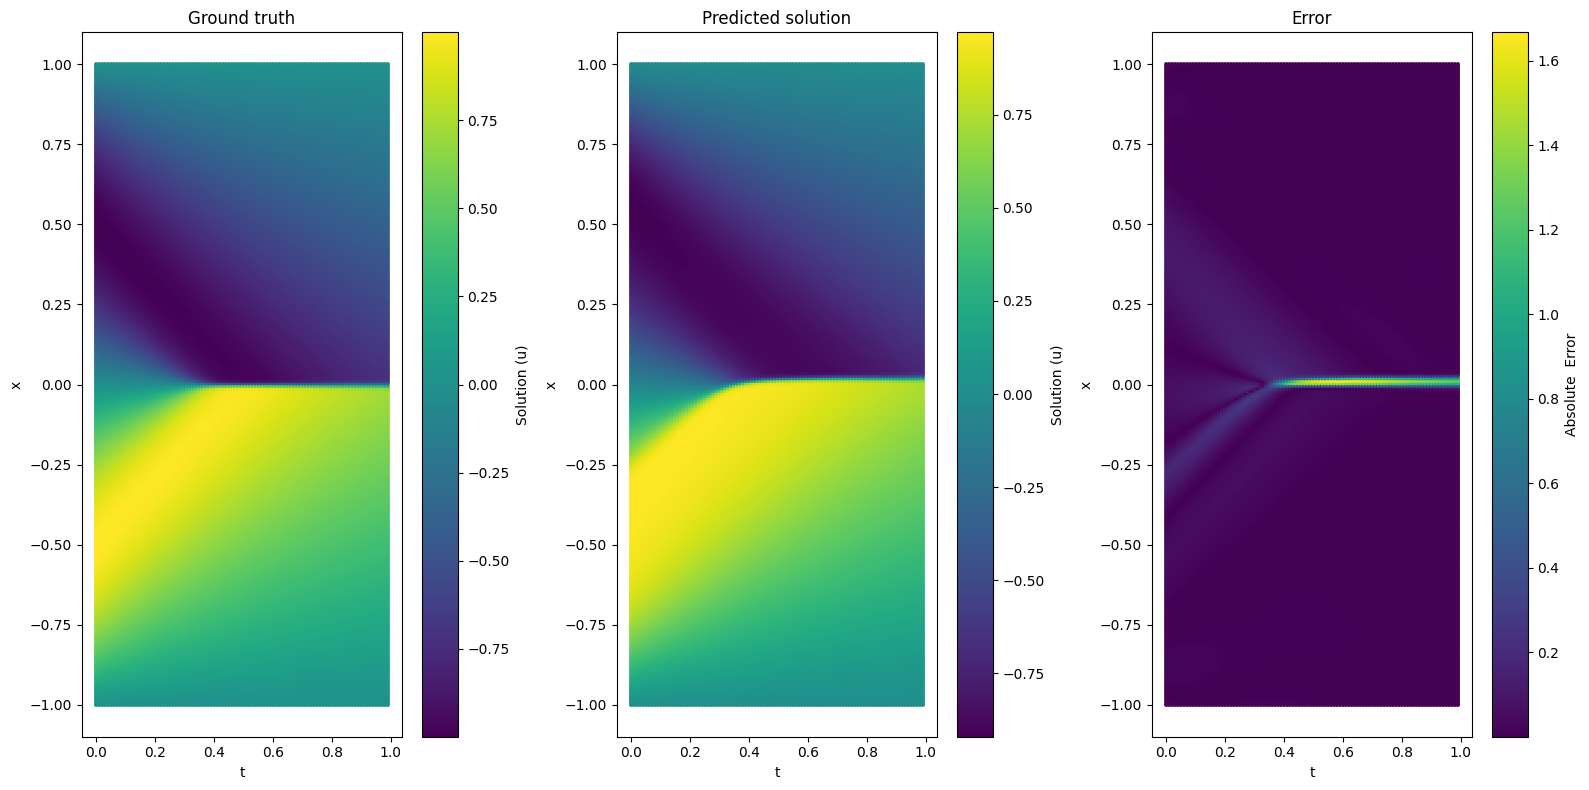

In [32]:
plt.figure(figsize=(16, 8))
plt.subplot(1,3,1)
plt.scatter(X_star[:,1:2], X_star[:,0:1], c = u_star, cmap = 'viridis', s = 5)
plt.colorbar(label='Solution (u)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Ground truth')

plt.subplot(1,3,2)
plt.scatter(X_star[:,1:2], X_star[:,0:1], c = U_pred, cmap = 'viridis', s = 5)
plt.colorbar(label='Solution (u)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Predicted solution')

plt.subplot(1,3,3)
plt.scatter(X_star[:,1:2], X_star[:,0:1], c = abs(u_star.reshape(U_pred.shape)-U_pred), cmap = 'viridis', s = 5)
plt.colorbar(label='Absolute  Error')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Error')

plt.tight_layout()
plt.show()